In [2]:
from __future__ import unicode_literals
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import itertools
from math import factorial
import datetime
import math

## MSE Functions

In [3]:
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    Y = np.empty((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T


def util_pattern_space(time_series, lag, dim):
    """Create a set of sequences with given lag and dimension
    Args:
       time_series: Vector or string of the sample data
       lag: Lag between beginning of sequences
       dim: Dimension (number of patterns)
    Returns:
        2D array of vectors
    """
    n = len(time_series)

    if lag * dim > n:
        raise Exception('Result matrix exceeded size limit, try to change lag or dim.')
    elif lag < 1:
        raise Exception('Lag should be greater or equal to 1.')

    pattern_space = np.empty((n - lag * (dim - 1), dim))
    for i in range(n - lag * (dim - 1)):
        for j in range(dim):
            pattern_space[i][j] = time_series[i + j * lag]

    return pattern_space


def util_standardize_signal(time_series):
    return (time_series - np.mean(time_series)) / np.std(time_series)


def util_granulate_time_series(time_series, scale):
    """Extract coarse-grained time series
    Args:
        time_series: Time series
        scale: Scale factor
    Returns:
        Vector of coarse-grained time series with given scale factor
    """
    n = len(time_series)
    b = int(np.fix(n / scale))
    temp = np.reshape(time_series[0:b*scale], (b, scale))
    cts = np.mean(temp, axis = 1)
    return cts


def shannon_entropy(time_series):
    """Return the Shannon Entropy of the sample data.
    Args:
        time_series: Vector or string of the sample data
    Returns:
        The Shannon Entropy as float value
    """

    # Check if string
    if not isinstance(time_series, str):
        time_series = list(time_series)

    # Create a frequency data
    data_set = list(set(time_series))
    freq_list = []
    for entry in data_set:
        counter = 0.
        for i in time_series:
            if i == entry:
                counter += 1
        freq_list.append(float(counter) / len(time_series))

    # Shannon entropy
    ent = 0.0
    for freq in freq_list:
        ent += freq * np.log2(freq)
    ent = -ent
    return ent


def sample_entropy(time_series, sample_length, tolerance = None):
    """Calculates the sample entropy of degree m of a time_series.
    This method uses chebychev norm.
    It is quite fast for random data, but can be slower is there is
    structure in the input time series.
    Args:
        time_series: numpy array of time series
        sample_length: length of longest template vector
        tolerance: tolerance (defaults to 0.1 * std(time_series)))
    Returns:
        Array of sample entropies:
            SE[k] is ratio "#templates of length k+1" / "#templates of length k"
            where #templates of length 0" = n*(n - 1) / 2, by definition
    Note:
        The parameter 'sample_length' is equal to m + 1 in Ref[1].
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    #The code below follows the sample length convention of Ref [1] so:
    M = sample_length - 1;

    time_series = np.array(time_series)
    if tolerance is None:
        tolerance = 0.1*np.std(time_series)

    n = len(time_series)

    #Ntemp is a vector that holds the number of matches. N[k] holds matches templates of length k
    Ntemp = np.zeros(M + 2)
    #Templates of length 0 matches by definition:
    Ntemp[0] = n*(n - 1) / 2


    for i in range(n - M - 1):
        template = time_series[i:(i+M+1)];#We have 'M+1' elements in the template
        rem_time_series = time_series[i+1:]

        searchlist = np.nonzero(np.abs(rem_time_series - template[0]) < tolerance)[0]

        go = len(searchlist) > 0;

        length = 1;

        Ntemp[length] += len(searchlist)

        while go:
            length += 1
            nextindxlist = searchlist + 1;
            nextindxlist = nextindxlist[nextindxlist < n - 1 - i]#Remove candidates too close to the end
            nextcandidates = rem_time_series[nextindxlist]
            hitlist = np.abs(nextcandidates - template[length-1]) < tolerance
            searchlist = nextindxlist[hitlist]

            Ntemp[length] += np.sum(hitlist)

            go = any(hitlist) and length < M + 1


    sampen =  - np.log(Ntemp[1:] / Ntemp[:-1])
    return sampen


def multiscale_entropy(time_series, sample_length, tolerance = None, maxscale = None):
    """Calculate the Multiscale Entropy of the given time series considering
    different time-scales of the time series.
    Args:
        time_series: Time series for analysis
        sample_length: Bandwidth or group of points
        tolerance: Tolerance (default = 0.1*std(time_series))
    Returns:
        Vector containing Multiscale Entropy
    Reference:
        [1] http://en.pudn.com/downloads149/sourcecode/math/detail646216_en.html
    """

    if tolerance is None:
        #we need to fix the tolerance at this level. If it remains 'None' it will be changed in call to sample_entropy()
        tolerance = 0.5*np.std(time_series) #originally defaulted at 0.1 but can be changed to 0.25
    if maxscale is None:
        maxscale = len(time_series)

    mse = np.zeros(maxscale)

    for i in range(maxscale): #skip every 20, less resolution but faster processing 
        now = datetime.datetime.now()
        if i == 0:
            print(now.strftime("%H:%M:%S"))
        elif i % 10 == 0:
            print(now.strftime("%H:%M:%S"))
        #print('index', i)
        temp = util_granulate_time_series(time_series, i+1)
        #print('granulated', i)
        mse[i] = sample_entropy(temp, sample_length, tolerance)[-1]
        #print('samp_ent', i)
    return mse


def permutation_entropy(time_series, order=3, delay=1, normalize=False):
    """Permutation Entropy.
    Parameters
    ----------
    time_series : list or np.array
        Time series
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Permutation Entropy
    References
    ----------
    .. [1] Massimiliano Zanin et al. Permutation Entropy and Its Main
        Biomedical and Econophysics Applications: A Review.
        http://www.mdpi.com/1099-4300/14/8/1553/pdf
    .. [2] Christoph Bandt and Bernd Pompe. Permutation entropy — a natural
        complexity measure for time series.
        http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf
    Notes
    -----
    Last updated (Oct 2018) by Raphael Vallat (raphaelvallat9@gmail.com):
    - Major speed improvements
    - Use of base 2 instead of base e
    - Added normalization
    Examples
    --------
    1. Permutation entropy with order 2
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value between 0 and log2(factorial(order))
        >>> print(permutation_entropy(x, order=2))
            0.918
    2. Normalized permutation entropy with order 3
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(permutation_entropy(x, order=3, normalize=True))
            0.589
    """
    x = np.array(time_series)
    hashmult = np.power(order, np.arange(order))
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


def multiscale_permutation_entropy(time_series, m, delay, scale):
    """Calculate the Multiscale Permutation Entropy
    Args:
        time_series: Time series for analysis
        m: Order of permutation entropy
        delay: Time delay
        scale: Scale factor
    Returns:
        Vector containing Multiscale Permutation Entropy
    Reference:
        [1] Francesco Carlo Morabito et al. Multivariate Multi-Scale Permutation Entropy for
            Complexity Analysis of Alzheimer’s Disease EEG. www.mdpi.com/1099-4300/14/7/1186
        [2] http://www.mathworks.com/matlabcentral/fileexchange/37288-multiscale-permutation-entropy-mpe/content/MPerm.m
    """
    mspe = []
    for i in range(scale):
        coarse_time_series = util_granulate_time_series(time_series, i + 1)
        pe = permutation_entropy(coarse_time_series, order=m, delay=delay)
        mspe.append(pe)
    return mspe


# TODO add tests
def composite_multiscale_entropy(time_series, sample_length, scale, tolerance=None):
    """Calculate the Composite Multiscale Entropy of the given time series.
    Args:
        time_series: Time series for analysis
        sample_length: Number of sequential points of the time series
        scale: Scale factor
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Composite Multiscale Entropy
    Reference:
        [1] Wu, Shuen-De, et al. "Time series analysis using
            composite multiscale entropy." Entropy 15.3 (2013): 1069-1084.
    """
    cmse = np.zeros((1, scale))

    for i in range(scale):
        for j in range(i):
            tmp = util_granulate_time_series(time_series[j:], i + 1)
            cmse[i] += sample_entropy(tmp, sample_length, tolerance) / (i + 1)
    return cmse

## MSE Replication 

In [17]:
##Stimulus
from scipy import signal
###########################################################
# sampling rate = total samples/length in seconds
#
# Resample: total samples = desired sampling rate*length in seconds
# length in seconds = total samples/original sampling rate
##########################################################

stim1 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/Philip_Glass_Glassworks_01_Opening.wav")
sarr1 = np.array(stim1[1][:],dtype=float)
sarr1 = np.mean(sarr1,axis=1)
t = len(stim1[1])/44100
new_sr = 11250
print('preresample')
sarr1 = signal.resample(sarr1, int(new_sr*t)) 

stim2 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/monteverdi_zefiro_torna.wav")
sarr2 = np.array(stim2[1][:],dtype=float)
sarr2 = np.mean(sarr2,axis=1)
t = len(stim2[1])/44100
new_sr = 11250
sarr2 = signal.resample(sarr2, int(new_sr*t)) 

stim3 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/Praeambulum_F.wav")
sarr3 = np.array(stim3[1][:],dtype=float)
sarr3 = np.mean(sarr3,axis=1)
t = len(stim3[1])/44100
new_sr = 11250
sarr3 = signal.resample(sarr3, int(new_sr*t)) 

preresample


C:\Users\cogmech\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\cogmech\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\cogmech\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array inde

In [3]:
stim1 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/Philip_Glass_Glassworks_01_Opening.wav")


In [19]:
print(len(sarr1),len(sarr2),len(sarr3))

4331363 5015771 1386318


In [29]:
len(sarr3)/2
#6/5.75


693159.0

In [30]:
sarr1_mse = multiscale_entropy(sarr1[0:753280], 3, None, 100) ##hard coded change to .5 on tolerance arg[1]=m+1
sarr2_mse = multiscale_entropy(sarr2[0:716538], 3, None, 100)
sarr3_mse = multiscale_entropy(sarr3[0:693159], 3, None, 100)

13:37:23
16:36:33
16:40:00
16:41:32
16:42:27
16:43:00
16:43:24
16:43:41
16:43:55
16:44:07
16:44:16
19:38:47
19:42:12
19:43:34
19:44:19
19:44:48
19:45:10
19:45:26
19:45:38
19:45:49
19:45:58
22:19:12
22:21:57
22:23:06
22:23:46
22:24:14
22:24:34
22:24:49
22:25:01
22:25:10


In [31]:
import pandas as pd

df1 = pd.DataFrame(sarr1_mse)
df1.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df1.csv")

df2 = pd.DataFrame(sarr2_mse)
df2.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df2.csv")

df3 = pd.DataFrame(sarr3_mse)
df3.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df3.csv")

In [4]:
import pandas as pd

df1 = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df1.csv") 
df2 = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df2.csv")
df3 = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df3.csv")

In [23]:
df1['0'].values


array([3.30152613e-01, 5.12813329e-01, 6.17803085e-01, 7.17054446e-01,
       8.16034617e-01, 8.96023865e-01, 9.47225096e-01, 9.67002429e-01,
       9.55544923e-01, 9.19447650e-01, 8.63863127e-01, 7.90191108e-01,
       6.95565048e-01, 5.99681921e-01, 5.46654474e-01, 5.27325255e-01,
       5.17743521e-01, 4.95540843e-01, 4.53906602e-01, 4.10020337e-01,
       3.67766202e-01, 3.34734856e-01, 3.09486143e-01, 2.88864475e-01,
       2.82474892e-01, 2.80105898e-01, 2.75630549e-01, 2.62984060e-01,
       2.48000709e-01, 2.37000021e-01, 2.28899219e-01, 2.15832563e-01,
       2.02959766e-01, 1.89089310e-01, 1.69931317e-01, 1.48113466e-01,
       1.28287421e-01, 1.09257350e-01, 9.56647310e-02, 7.94051333e-02,
       6.52239024e-02, 5.25962783e-02, 4.17623264e-02, 3.40666931e-02,
       2.94464012e-02, 2.54944351e-02, 2.18108568e-02, 2.14481912e-02,
       1.72121663e-02, 1.74971538e-02, 1.82484878e-02, 1.70756960e-02,
       1.74037745e-02, 1.62152928e-02, 1.76293870e-02, 1.66950492e-02,
      

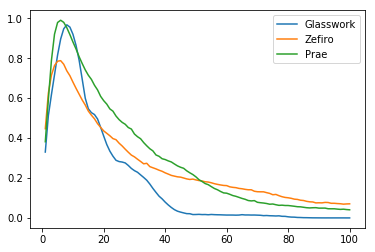

In [32]:
plt.plot(range(1,101),df1['0'].values, range(1,101),df2['0'].values,range(1,101),df3['0'].values)#,range(1,101),sarr2_mse,range(1,101),sarr3_mse)
plt.legend(['Glasswork','Zefiro','Prae'])
#plt.title('Log')

In [25]:
from scipy.signal import hilbert, chirp

amp1 = np.abs(hilbert(df1['0'].values))
amp2 = np.abs(hilbert(df2['0'].values))
amp3 = np.abs(hilbert(df3['0'].values))

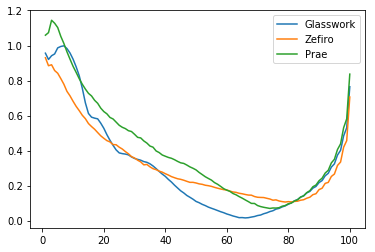

In [26]:
plt.plot(range(1,101),amp1, range(1,101),amp2,range(1,101),amp3)
plt.legend(['Glasswork','Zefiro','Prae'])

## Version 2

In [54]:
##Stimulus
from scipy import signal
###########################################################
# sampling rate = total samples/length in seconds
#
# Resample: total samples = desired sampling rate*length in seconds
# length in seconds = total samples/original sampling rate
##########################################################

stim1 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/Philip_Glass_Glassworks_01_Opening.wav")
sarr1 = np.array(stim1[1][:],dtype=float)
sarr1 = np.mean(sarr1,axis=1)
amp1 = np.abs(hilbert(sarr1))
t = len(stim1[1])/44100
new_sr = 5000
#print('preresample')
sarr1 = signal.resample(amp1, int(new_sr*t)) 

stim2 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/monteverdi_zefiro_torna.wav")
sarr2 = np.array(stim2[1][:],dtype=float)
sarr2 = np.mean(sarr2,axis=1)
amp2 = np.abs(hilbert(sarr2))
t = len(stim2[1])/44100
new_sr = 5000
sarr2 = signal.resample(amp2, int(new_sr*t)) 

stim3 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/Praeambulum_F.wav")
sarr3 = np.array(stim3[1][:],dtype=float)
sarr3 = np.mean(sarr3,axis=1)
amp3 = np.abs(hilbert(sarr3))
t = len(stim3[1])/44100
new_sr = 5000
sarr3 = signal.resample(amp3, int(new_sr*t)) 

In [57]:
len(sarr3)/2


308070.5

In [58]:
sarr1_mse = multiscale_entropy(sarr1[0:320280], 3, None, 200) ##hard coded change to .5 on tolerance arg[1]=m+1
sarr2_mse = multiscale_entropy(sarr2[0:318538], 3, None, 200)
sarr3_mse = multiscale_entropy(sarr3[0:308159], 3, None, 200)

00:09:56
00:30:16
00:30:55
00:31:11
00:31:21
00:31:28
00:31:33
00:31:36
00:31:40
00:31:42
00:31:45
00:31:47
00:31:48
00:31:50
00:31:51
00:31:53
00:31:54
00:31:55
00:31:56
00:31:57
00:31:58
00:58:28
00:59:07
00:59:23
00:59:32
00:59:39
00:59:44
00:59:47
00:59:51
00:59:53
00:59:55
00:59:57
00:59:59
01:00:01
01:00:02
01:00:03
01:00:04
01:00:06
01:00:07
01:00:07
01:00:08
01:22:22
01:23:00
01:23:15
01:23:24
01:23:30
01:23:35
01:23:39
01:23:42
01:23:44
01:23:46
01:23:48
01:23:50
01:23:51
01:23:53
01:23:54
01:23:55
01:23:56
01:23:57
01:23:58


In [59]:
df1_5khz = pd.DataFrame(sarr1_mse)
df1_5khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df1_200amp5khz.csv")

df2_5khz = pd.DataFrame(sarr2_mse)
df2_5khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df2_200amp5khz.csv")

df3_5khz = pd.DataFrame(sarr3_mse)
df3_5khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df3_200amp5khz.csv")

In [52]:
df1_11khz = pd.DataFrame(sarr1_mse)
df1_11khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df1_200amp11khz.csv")

df2_11khz = pd.DataFrame(sarr2_mse)
df2_11khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df2_200amp11khz.csv")

df3_11khz = pd.DataFrame(sarr3_mse)
df3_11khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df3_200amp11khz.csv")

In [49]:
df1_11khz = pd.DataFrame(sarr1_mse)
df1_11khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df1_amp11khz.csv")

df2_11khz = pd.DataFrame(sarr2_mse)
df2_11khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df2_amp11khz.csv")

df3_11khz = pd.DataFrame(sarr3_mse)
df3_11khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df3_amp11khz.csv")

In [41]:
df1_5khz = pd.DataFrame(sarr1_mse)
df1_5khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df1_amp5khz.csv")

df2_5khz = pd.DataFrame(sarr2_mse)
df2_5khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df2_amp5khz.csv")

df3_5khz = pd.DataFrame(sarr3_mse)
df3_5khz.to_csv("/Users/cogmech/Documents/Neuro Complexity Matching/data/replication/df3_amp5khz.csv")

In [30]:
amp1 = np.abs(hilbert(sarr1_mse))
amp2 = np.abs(hilbert(sarr2_mse))
amp3 = np.abs(hilbert(sarr3_mse))

Text(0.5, 1.0, '5khz Amplitude MSE')

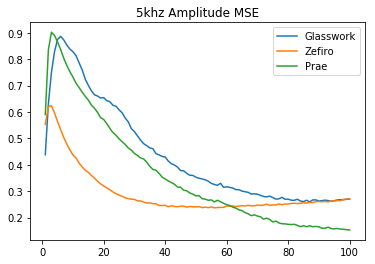

In [43]:
plt.plot(range(1,101),sarr1_mse, range(1,101),sarr2_mse,range(1,101),sarr3_mse)
plt.legend(['Glasswork','Zefiro','Prae'])
plt.title('5khz Amplitude MSE')

Text(0.5, 1.0, '11khz Amplitude MSE')

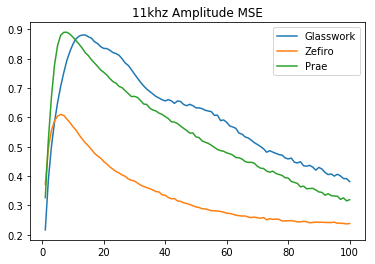

In [50]:
plt.plot(range(1,101),sarr1_mse, range(1,101),sarr2_mse,range(1,101),sarr3_mse)
plt.legend(['Glasswork','Zefiro','Prae'])
plt.title('11khz Amplitude MSE')

Text(0.5, 1.0, '11khz Amplitude MSE')

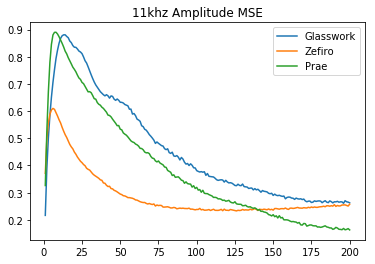

In [53]:
plt.plot(range(1,201),sarr1_mse, range(1,201),sarr2_mse,range(1,201),sarr3_mse)
plt.legend(['Glasswork','Zefiro','Prae'])
plt.title('11khz Amplitude MSE')

Text(0.5, 1.0, '5khz Amplitude MSE')

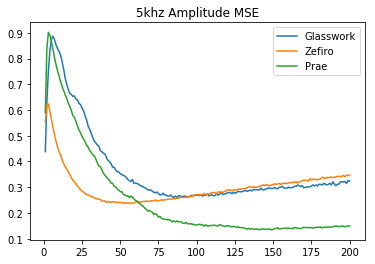

In [60]:
plt.plot(range(1,201),sarr1_mse, range(1,201),sarr2_mse,range(1,201),sarr3_mse)
plt.legend(['Glasswork','Zefiro','Prae'])
plt.title('5khz Amplitude MSE')